## Загружаем данные.

In [98]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

### https://drive.google.com/file/d/1nw-30yxFPOIHE_46cBt2Vet-gqjWS9uB/view?usp=sharing

Ссылка с параметрами : доступно всем в интернете. читатель.

In [3]:
!gdown --id 1nw-30yxFPOIHE_46cBt2Vet-gqjWS9uB

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1nw-30yxFPOIHE_46cBt2Vet-gqjWS9uB
To: /content/scanner_data.csv
100% 6.16M/6.16M [00:00<00:00, 28.8MB/s]


In [4]:
df = pd.read_csv('/content/scanner_data.csv')

In [5]:
%load_ext google.colab.data_table
from vega_datasets import data
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [6]:
# посмотрим на пропуски и форматы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [7]:
# дропнем пустой столбец
df = df.drop(['Unnamed: 0'],axis=1)

In [8]:
# переведем строку в дату
df.Date = pd.to_datetime(df['Date'],format='%d/%m/%Y')

In [ ]:
# глянет на дубликаты
df.duplicated().sum()

In [11]:
# все в строчный формат
df.columns = (df.columns.str.lower())

In [24]:
# сократим размер наших данных, необходимых для анализа с помощью группировки
df = df.groupby(['date','customer_id']).agg({'transaction_id': max,'sku_category' : max,'sku' : max,\
                                        'quantity' : sum,'sales_amount': sum}).reset_index()

In [39]:
# получим месяц покупки
df['buy_month'] = df['date'].apply(lambda x: dt.date(x.year, x.month,1))

In [43]:
# получим первый месяц покупки
df['first_buy_month'] = df.groupby('customer_id')['buy_month'].transform('min')

In [48]:
# теперь посчитаем "период жизни" - вычтем из даты покупки первый месяц покупки. Прибавим + 1 , чтобы период начинался с 1
df['cohort_idx'] = ((df['buy_month'] - df['first_buy_month']) / np.timedelta64(1,'M')).round() +1

In [68]:
# получим размер когороты, тоесть, сколько клиентов было 
size = df.groupby('first_buy_month')['customer_id'].nunique().reset_index()
size = size.rename(columns={'customer_id' : 'coh_size'})

In [74]:
# посчитаем, сколько клиентов было на опеределенный период
r = df.groupby(['first_buy_month','cohort_idx'])['customer_id'].nunique().reset_index()

In [76]:
# добавить в таблицу размер когорт
r = r.merge(size,on = 'first_buy_month')

In [78]:
# получаем retention
r['retention_rate'] = r['customer_id'] / r['coh_size']

In [107]:
# группируем и суммируем показатель retention, группируем и получаем процент
retention_pivot = round(r.pivot_table(index = 'first_buy_month', columns = 'cohort_idx', values = 'retention_rate', aggfunc = 'sum')*100,1)

In [124]:
# группируем и суммируем показатель retention, получаем абсолют
retention_pivot_abs = r.pivot_table(index = 'first_buy_month', columns = 'cohort_idx', values = 'customer_id', aggfunc = 'sum')

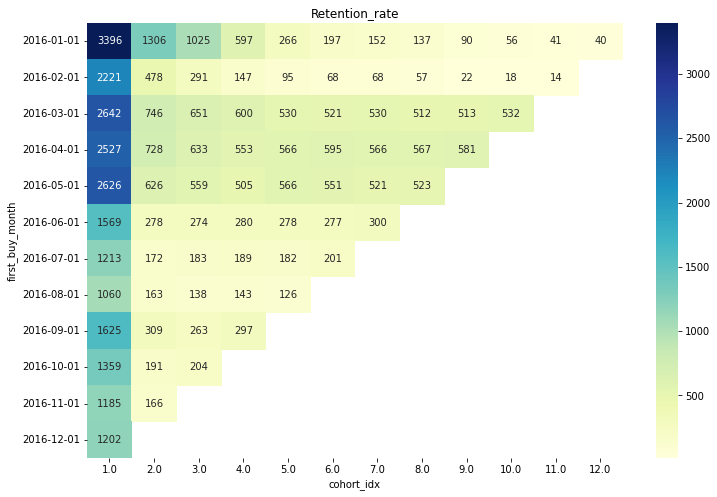

In [125]:
# визуализируем абсолют
plt.figure(figsize=(12,8))
plt.title('Retention_rate_absolute')
sns.heatmap(retention_pivot_abs,annot=True,fmt='g',label='ret',cmap="YlGnBu")
plt.show()

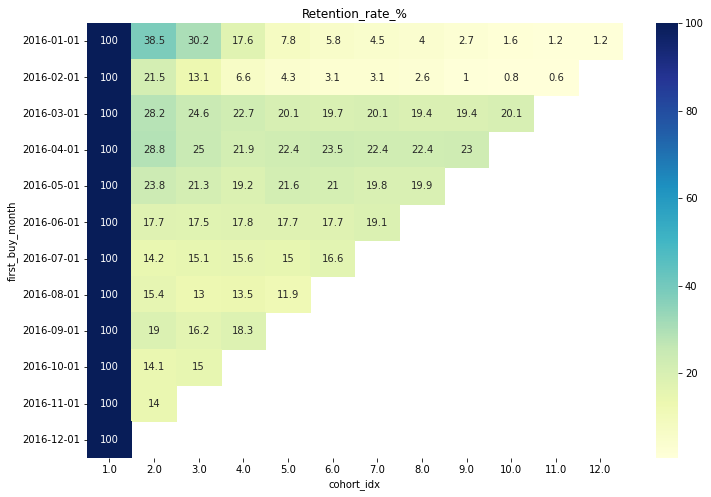

In [126]:
# визуализируем %
plt.figure(figsize=(12,8))
plt.title('Retention_rate_%')
sns.heatmap(retention_pivot,annot=True,fmt='g',label='ret',cmap="YlGnBu")
plt.show()

- Стоит обратить внимание, что после мая резко упал % возврата клиентов
- Самый высокий показатель январь => февраль 2016